# Linking to parent datasets

When performing a measurement in QCoDeS, it is possible to annotate the outcome (the dataset) of that measurement as having one or more parent datasets. This is done by adding a link to each parent dataset. This notebook covers the mechanisms to do that by going through a few practical examples.

In [1]:
import os
import datetime

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.data_set import load_by_run_spec
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/201030-15146-qcodes.log


In [2]:
now = str(datetime.datetime.now())
tutorial_db_path = os.path.join(os.getcwd(), 'linking_datasets_tutorial.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment('tutorial ' + now, 'no sample')

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 348.16it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 339.26it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 646.07it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 306.67it/s]

tutorial 2020-10-30 16:11:14.740898#no sample#1@/home/vsts/work/1/s/docs/examples/DataSet/linking_datasets_tutorial.db
----------------------------------------------------------------------------------------------------------------------

## Example 1: Measuring and then fitting

Say we measure some raw data and subsequently do a curve fit to those data. We'd like to save the fit as a separate dataset that has a link to the dataset of the original data. This is achieved in two steps.

### Step 1: measure raw data

In [3]:
meas = Measurement()
meas.register_custom_parameter(name='time',
                               label='Time', unit='s',
                               paramtype='array')
meas.register_custom_parameter(name='signal',
                               label='Signal', unit='V',
                               paramtype='array',
                               setpoints=['time'])

N = 500

with meas.run() as datasaver:
    time_data = np.linspace(0, 1, N)
    signal_data = np.sin(2*np.pi*time_data) + 0.25*np.random.randn(N)
    
    datasaver.add_result(('time', time_data), ('signal', signal_data))
dataset = datasaver.dataset

Starting experimental run with id: 1. 


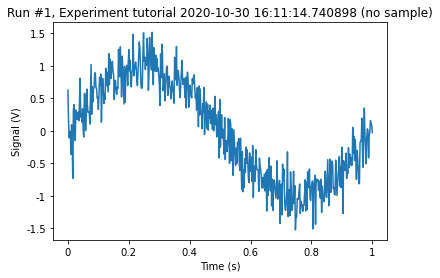

In [4]:
cbs, axs = plot_dataset(dataset)

### Step 2: Set up a fit "measurement"

We now load the raw data dataset, set up a new measurement for the fit, register the raw data as a parent and save a fit.

As the very first step, we supply a model to fit to.

In [5]:
def fit_func(x, a, b):
    return a*np.sin(2*np.pi*x)+b

Next, we set up the fitting measurement.

In [6]:
raw_data = load_by_run_spec(captured_run_id=dataset.captured_run_id)

meas = Measurement()
meas.register_custom_parameter('fit_axis',
                               label='Fit axis', unit='t',
                               paramtype='array')
meas.register_custom_parameter('fit_curve',
                               label='Fitted curve', unit='V',
                               paramtype='array',
                               setpoints=['fit_axis'])
meas.register_custom_parameter('fit_param_a',
                               label='Fitted parameter amplitude',
                               unit='V')
meas.register_custom_parameter('fit_param_b',
                               label='Fitted parameter offset',
                               unit='V')
meas.register_parent(parent=raw_data, link_type="curve fit")

As we now run the measurement, the parent datasets become available via the datasaver. The datasets appear in the order they were registered.

In [7]:
with meas.run() as datasaver:
    raw = datasaver.parent_datasets[0]
    xdata = np.ravel(raw.get_parameter_data()['signal']['time'])
    ydata = np.ravel(raw.get_parameter_data()['signal']['signal'])
    
    popt, pcov = opt.curve_fit(fit_func, xdata, ydata, p0=[1, 1])
    
    fit_axis = xdata
    fit_curve = fit_func(fit_axis, *popt)
    
    datasaver.add_result(('fit_axis', fit_axis),
                         ('fit_curve', fit_curve),
                         ('fit_param_a', popt[0]),
                         ('fit_param_b', popt[1]))
    
fit_data = datasaver.dataset

Starting experimental run with id: 2. 


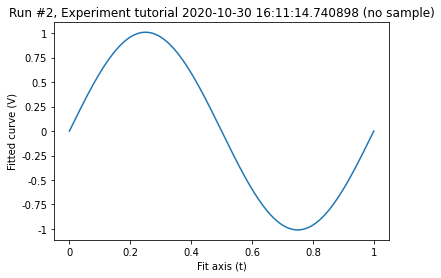

In [8]:
cbs, axs = plot_dataset(fit_data)

And just for completeness, let us plot both datasets on top of each other.

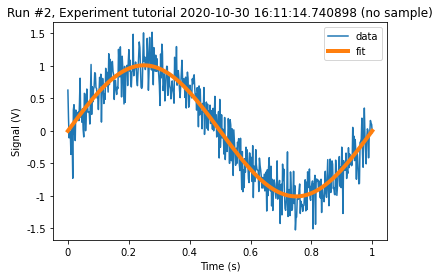

In [9]:
fig, ax = plt.subplots(1)
cbs, axs = plot_dataset(raw_data, axes=ax, label='data')
cbs, axs = plot_dataset(fit_data, axes=ax, label='fit', linewidth=4)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (V)')
plt.legend()